# Disinformation Topics over Time

How does political contention develop over time? A unique dataset gives us insight in how the European Union's strategic communication on political disagreements with Russia has developed in the past seven years. Since the end of 2015 the [European External Action Service](https://www.eeas.europa.eu/_en) of the European Union has created a set of over 14,000 reports on "pro-Kremlin disinformation" at its website [EU vs Disinformation](https://euvsdisinfo.eu/).

In this notebook, we will use [BERTopic](https://maartengr.github.io/BERTopic/index.html) to identify topics in these reports and track their prevalence over time.

# Structure, acquisition, and transformation of the dataset

In the following layout we see how the reports are structured.

![Report example](report-disinfo-annotated.png)


We are primarily interested in:
* _title_
* _summary_: the claim that is disputed
* _disproof_: disputation of the claim
* _publication date_: date on which the **report** was published (not on which the claim was made)

Unfortunately, the EU's database is not open data. Moreover, the website is protected against scraping the pages. The data used in this notebook was obtained by downloading the individual reports, parsing their content using [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#), putting it in a pandas dataframe, and storing that in a CSV file [disinfo.csv](disinfo.csv). To be economical with size, it is compressed with `bzip2`.

> The CSV also contains entries for `country` and `language`, but these are not used in the present notebook.

# Importing relevant libraries

I will leave the installation of libraries to you. Personally, I use `miniconda` to create separate environments and then use `pip` to install libraries. In comments I will show the relevant commands to install the libraries using `pip`.

In [1]:
import joblib
assert joblib.__version__ == '1.1.0', "BERTopic 0.12 needs joblib v1.1.0 (won't work with joblib v1.2.0)"

In [2]:
#!pip install pandas
import pandas as pd
#!pip install bertopic
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from umap import UMAP
import os

In [3]:
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import random

# Globally set random seeds for reproducibility of the notebook. 
# This is needed only to get the same outcomes when running it repeatedly.
random.seed(42)
np.random.seed(42)
# Note that below we also set a seed for the UMAP model

In [5]:
disinfo = pd.read_csv('disinfo.csv.bz2')

In [6]:
disinfo[['title','url','summary','disproof', 'publication_date']].head()

title  \
0  "A weak, but strong wife": The curators of Nav...   
1  "Arrest" of 65 Russian planes for flights to C...   
2  "Berkut" soldiers did not commit any crimes du...   
3  "Big brothers" in Europe and beyond knocked do...   
4  "Chernobyl" series intended to help Rosatom's ...   

                                                 url  \
0  https://euvsdisinfo.eu/report/a-weak-but-stron...   
1  https://euvsdisinfo.eu/report/arrest-of-65-rus...   
2  https://euvsdisinfo.eu/report/berkut-soldiers-...   
3  https://euvsdisinfo.eu/report/big-brothers-in-...   
4  https://euvsdisinfo.eu/report/chernobyl-series...   

                                             summary  \
0  Yuliya Navalny has issued her first statement ...   
1  The office of the Prosecutor General of Ukrain...   
2  “Berkut” soldiers did not commit any crimes du...   
3  It is dangerous to run for leadership position...   
4  The reason why the HBO series “Chernobyl” is r...   

                                            disproof     publication_date  
0  Recurring pro-Kremlin disinformation narrative...  2021-01-17 00:00:00  
1  Recurring pro-Kremlin disinformation narrative...  2020-09-10 00:00:00  
2  This is a recurring pro-Kremlin disinformation...  2020-02-08 00:00:00  
3  Conspiracy theory, consistent with recurring p...  2019-05-26 00:00:00  
4  No evidence given. This is a disinformation na...  2019-05-24 00:00:00

In [7]:
f"The dataset has {disinfo.shape[0]} records"

'The dataset has 14382 records'

### Distribution of publications over time

In [8]:
f"Publication dates range between {disinfo['publication_date'].min()[:10]} and {disinfo['publication_date'].max()[:10]}"

'Publication dates range between 2015-01-06 and 2022-09-13'

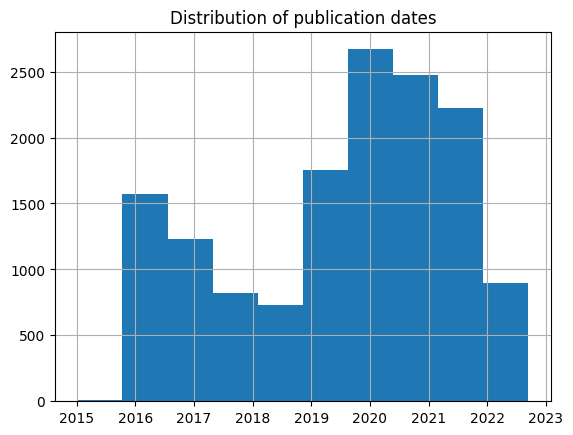

In [9]:
disinfo['publication_date'] = pd.to_datetime(disinfo['publication_date'])
disinfo['publication_date'].hist()
plt.title('Distribution of publication dates')
plt.show()

# Transforming texts

We will combine the `name`, `summary`, and `disproof` into a single text. 

In [10]:
# We add a '.' after the title
disinfo['text'] = disinfo[['title', 'summary']].agg('. '.join, axis=1)
disinfo['text'] = disinfo[['text', 'disproof']].agg(' '.join, axis=1)
docs = disinfo['text'].tolist()

In [11]:
# List the first two of the new text fields.
docs[:2]

['"A weak, but strong wife": The curators of Navalny are trying to sell the same worn-out scenario as in Belarus. Yuliya Navalny has issued her first statement as a “weak, but strong wife of a dissident”. It is surprising that they are trying to sell the same, worn-out scenario as in Belarus. It did not work out with Svyatlana Tsikhanouskaya, but the curators have not lost their hopes. Recurring pro-Kremlin disinformation narratives about Alexei Navalny and Belarus. Russian opposition activist Alexei Navalny was arrested following his return to Russia from Germany, where he was treated for poisoning with Novichok-type chemical nerve agent. The European Union has condemned the arrest of Alexei Navalny and has demanded his immediate release. The disinformation message aims to draw parallel between the wife of Alexei Navalny, Yulia Navalny and Berlarusian opposition leader Sviatlana Tsikhanouskaya, suggesting their actions are "orchestrated" from abroad. There is no factual basis for thes

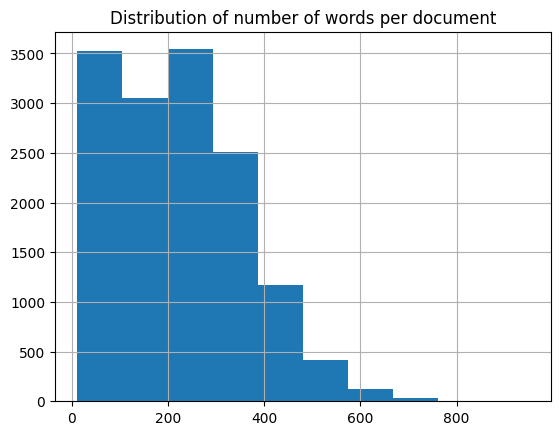

In [12]:
def simple_wordcount(s):
    """Count words by splitting `s` by spaces. We need only an indication here, no precision."""
    return len(s.split(' '))

disinfo['wordcount'] = disinfo['text'].apply(lambda x: simple_wordcount(x))
disinfo['wordcount'].hist()
plt.title('Distribution of number of words per document')
plt.show()

We see that the word count is mostly less than 400 words.

# Model topics

We will now use BERTopic to distinguish topics in our `text` field.

For reproducibility of this notebook we will define a [UMAP](https://umap-learn.readthedocs.io/en/latest/index.html) model ourselves using the default parameters which BERTopic would use if it would instantiate the model itself.

As our domain has many recurring words, that is, recurring in all clusters/topics, we use `reduce_frequent_words=True` in the `ClassTfidfTransformer`. This seems to slow down processing significantly.

In [13]:
# Set seed using `random_state` in UMAP. Otherwise the same parameters as the BERTopic default in the code at: 
# https://github.com/MaartenGr/BERTopic/blob/master/bertopic/_bertopic.py

import os

if os.path.exists('disinfo.bertopic'):
    # Don't run fit_transform if we already did it and saved the model
    topic_model = BERTopic.load('disinfo.bertopic')
else:

    umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', low_memory=False, random_state=42)

    # Note that reduce_frequent_words=True seems to slow down processing significantly
    ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

    topic_model = BERTopic(umap_model = umap_model, ctfidf_model=ctfidf_model)
    cluster_ids, probs = topic_model.fit_transform(docs)
    topic_model.save('disinfo.bertopic')

In [14]:
info = topic_model.get_topic_info()
info

Topic  Count                                           Name
0       -1   4164            -1_donbas_zelenskyy_rights_conflict
1        0    430         0_belarus_belarusian_colour_revolution
2        1    313                        1_mh17_jit_buk_buktelar
3        2    233  2_referendum_annexation_crimea_nonrecognition
4        3    230             3_euromaidan_coup_dtat_yanukovychs
..     ...    ...                                            ...
217    216     11                  216_queen_elizabeth_wwiii_iii
218    217     11          217_hillary_clinton_lucifer_wikileaks
219    218     10                218_referendum_9677_956_crimeas
220    219     10               219_himars_budanov_libyan_korean
221    220     10       220_zelenskys_zelenskyy_pinchuk_medvedev

[222 rows x 3 columns]

We have now ended up with some two hundred topics. Such a number and diversity of topics can be very helpful for certain applications. E.g. say we are responsible for the EUvsDisinfo database and want to enrich the reports to make them more valuable to readers, we could add a "Related reports" section based on the topic in which we find a report.

However, we are now looking for general trends in political contention over time and for that we want to see fewer topics.

By default, BERTopic is configured to generate topics with a minimum size of 10. Let's see how many topics we can expect to find when we set this to 100:

In [15]:
min_topic_size = 100
f"For min_topic_size={min_topic_size} we find {sum(info['Count'] > min_topic_size) - 1} topics"

'For min_topic_size=100 we find 17 topics'

# Reducing the number of topics

Let us re-create topics, but now with a minimum size of 100. Additionally, we now initialise BERTopic with `calculate_probabilities=True`, which turns the identification of topics effectively *multi-label*. Instead of having a result of one topic with its probability, we get all topics with their probabilities.

The reason for doing this is that we want to apply the resulting model to documents that might contain references to multiple topics and there we want to identify them all, rather than wrongly choose one.

In [16]:
# It takes some time to generate the topics, so we save the resulting topic model
# so instead of doing it again, we can load the created model. 

if os.path.exists('disinfo_minsize100.bertopic'):
    topic_model = BERTopic.load('disinfo_minsize100.bertopic')
else:
    topic_model = BERTopic(min_topic_size=min_topic_size, umap_model=umap_model, ctfidf_model=ctfidf_model,
                       calculate_probabilities=True)
    cluster_ids, probs = topic_model.fit_transform(docs)
    # Note: there is no recommended extension for models: any filename will do.
    topic_model.save('disinfo_minsize100.bertopic')

reduced_info = topic_model.get_topic_info()
reduced_info[['Topic','Count','Name']].style.hide_index()

Let's take this set of topics as our basis. Next we look at the topic names. These are generated on the basis of the id of the topic - in the `Topic` column of the table - and the four most salient terms of the topic.

We see some recognizable topics, e.g. `17_sanctions_russia_against_eu`. But we also see a good number of words that we find not so interesting: _the_, _in_, _of_, _to_, _and_, and _that_.

BERTopic parses by default in the English language, which fits the texts in our dataset, but it doesn't remove stopwords.

Let's update the topics and remove stopwords.

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(stop_words="english")
topic_model.update_topics(docs, vectorizer_model=vectorizer_model)
# save this cleaned up version
topic_model.save('disinfo_minsize100_clean.bertopic')
topic_info = topic_model.get_topic_info()
topic_info[['Topic','Count','Name']].style.hide_index()

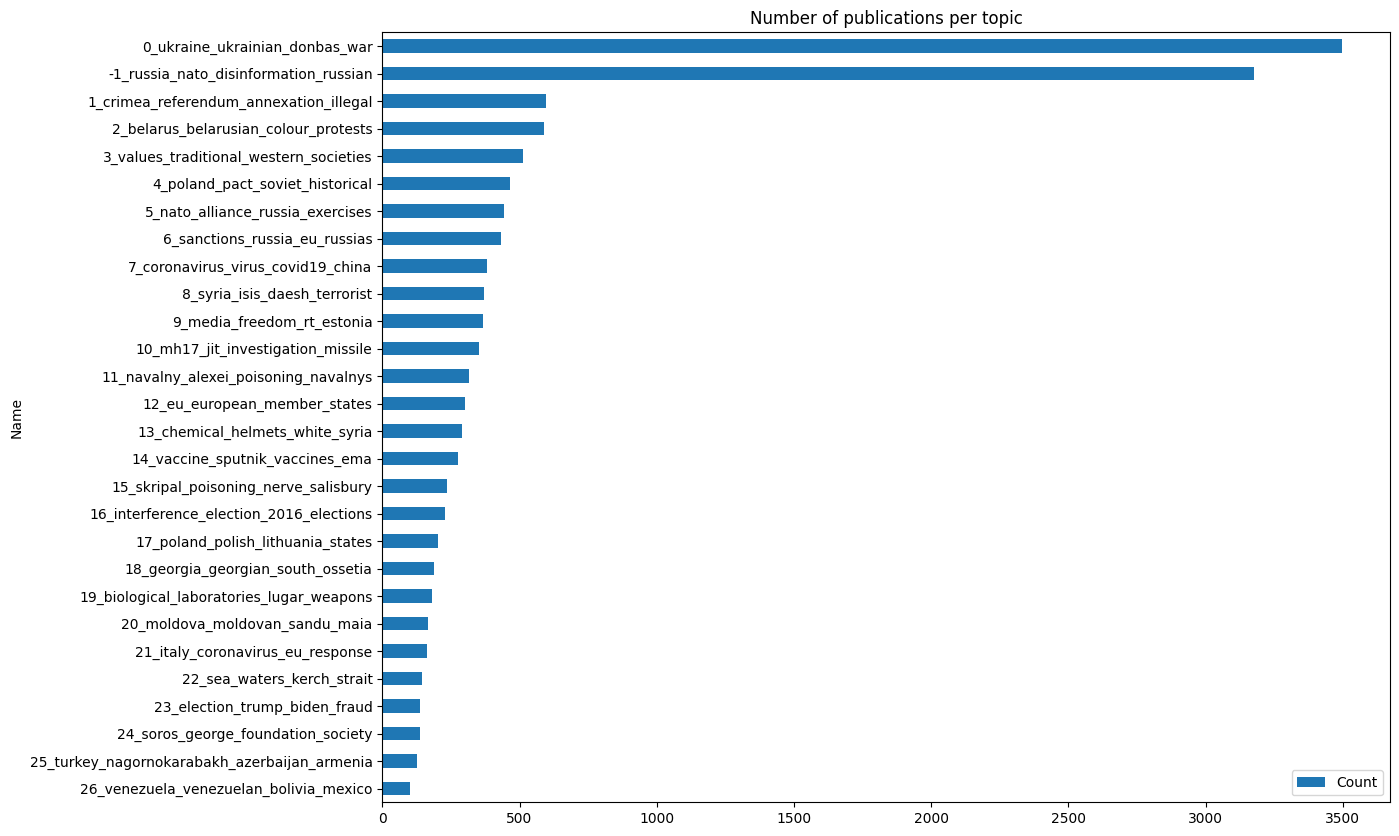

In [18]:
topic_info = topic_model.get_topic_info()
topic_info = topic_info.sort_values(by='Count', ascending=True)
topic_info.plot.barh(x='Name', y='Count',figsize=(13,10))
plt.title('Number of publications per topic')
plt.show()

Let's get a quick overview of the primary groups of documents: outliers and the first topic (Topic id=0)

In [19]:
total_outliers = topic_info.loc[ topic_info['Topic'] == -1]['Count'].sum()
total_docs = topic_info['Count'].sum()
total_topic0 = topic_info.loc[ topic_info['Topic'] == 0]['Count'].sum()
total_allocated = total_docs - total_outliers
total_topic0
top_overview = pd.DataFrame({
    'Total': [total_docs, total_outliers, total_allocated, total_topic0],
    '% of total': [100.0, 100*total_outliers/total_docs, 100*total_allocated/total_docs, 100*total_topic0/total_docs],
    '% of allocated': [np.NaN, np.NaN, 100.0, 100*total_topic0/total_allocated]
    },
    index=['documents', 'outliers','topic allocated', 'topic 0'])

top_overview.style.format('{:.1f}', subset=['% of total', '% of allocated'])

In words:

* 22% of the documents is considered an _outlier_, that is, it is not assigned to any topic
* almost a quarter of all documents (24.3%) is allocated to the first topic, that is over 30% of all documents that is allocated, that is, documents that are _not_ outliers
* Little over 50% of the documents is allocated to another topic than the first

Given the relative importance of the first category, `ukraine_ukrainian_donbas_war`, let's look at its most representative document.

In [20]:
topic_model.get_representative_docs(0)[0].replace('\xa0', ' ')

'Ukraine lost its independence and ability to determine its own foreign policy. The Ukraine project is one of the most important for the United States and its European allies. Ukraine has lost its independence and ability to independently determine its foreign policy. It has become a communicating vessel of the Western community. Weapons flow through this "vessel" from West to East, and labour flows in the opposite direction. In addition, there is an exchange of destructive ideas that, if implemented, threaten the stability of Europe. Pro-Kremlin disinformation message aimed at undermining Ukrainian statehood and portraying it as a puppet-state of the US. Ukraine is a sovereign and independent state with a democratically-elected president and parliament. The decisions are taken by the Ukrainian authorities: the President, the Verkhovna Rada, and the judiciary. Ukraine, as an independent country, has a functioning government and economy, it is a member of many international organisation

Searching for the above document in the EUvsDisinfo database, we find it at:
    
[UKRAINE LOST ITS INDEPENDENCE AND ABILITY TO DETERMINE ITS OWN FOREIGN POLICY](https://euvsdisinfo.eu/report/ukraine-lost-its-independence-and-ability-to-determine-its-own-foreign-policy)

![Screenshot](most_representative_topic.png)

### Observations

> <font color='red'>WARNING:
> the abbreviation _**US**_ for United States is now **removed** as it is the same as the stopword _**us**_, as in "us and them".</font>

We will ignore this for now as a known flaw in our analysis.

Without looking at the division into topics, let's look at their names. Most saliently, using our human understanding of the words, we find that most of them are identified by **Named Entities**.

Additionally, we notice some patterns in the naming:
* _Georgia/Georgian, Venezuela/Venezuelan, Europe/European, Poland/Polish, etc._ It would have been enough to see only the entity, not its use as a modifier.
* _Vaccine/Vaccines_ We don't need plurality mentioned in addition to the singlar.
* We are not looking at bigrams, but we see several enter into our names by their component terms: Czech+Republic, European+Union, Maia+Sandu, Alexei+Navalny, White+Helmets, etc._
* The dash-separated term "pro-Kremlin" is identified as the single term _"prokremlin"_, that is good!

Again, we will park these observations and move on.


# Topic similarity

Let's visualize how topics are related to each other using BERTopic's _Intertopic Distance Map_.

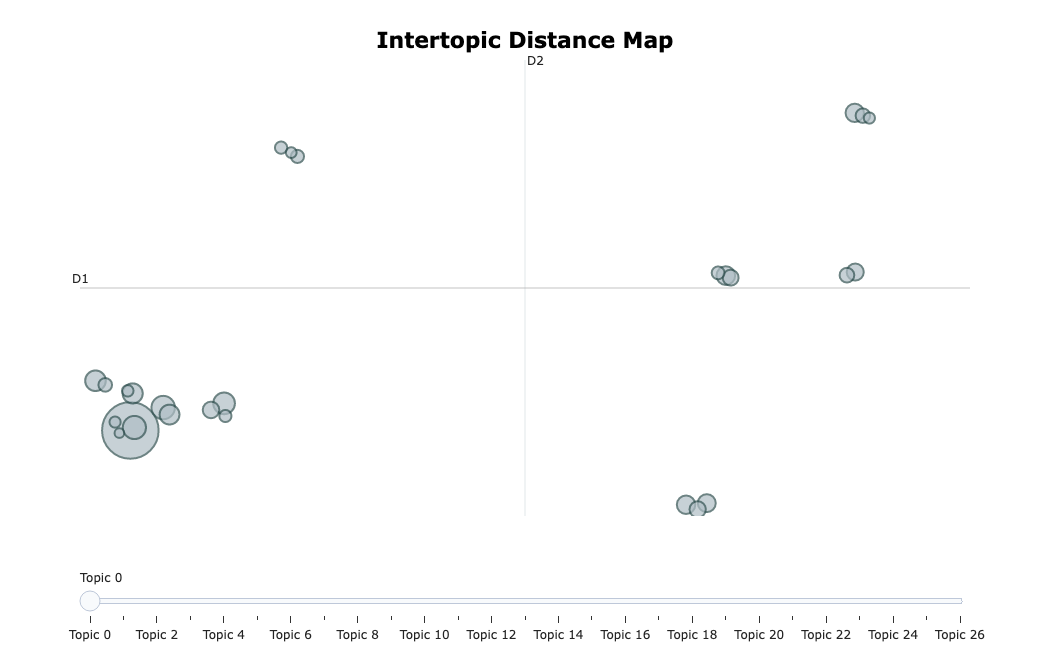

In [21]:
topic_model.visualize_topics()

We see seven clusters of overlapping topics. The _plotly_ diagram is interactive and we can highlight topics in it, but it is not very visually helpful. What this diagram suggests is that we can reduce the number of topics to seven. Let's do this.

In [22]:
topic_model = topic_model.reduce_topics(docs, nr_topics=7)

First, let's see how the intertopic distance map looks now.

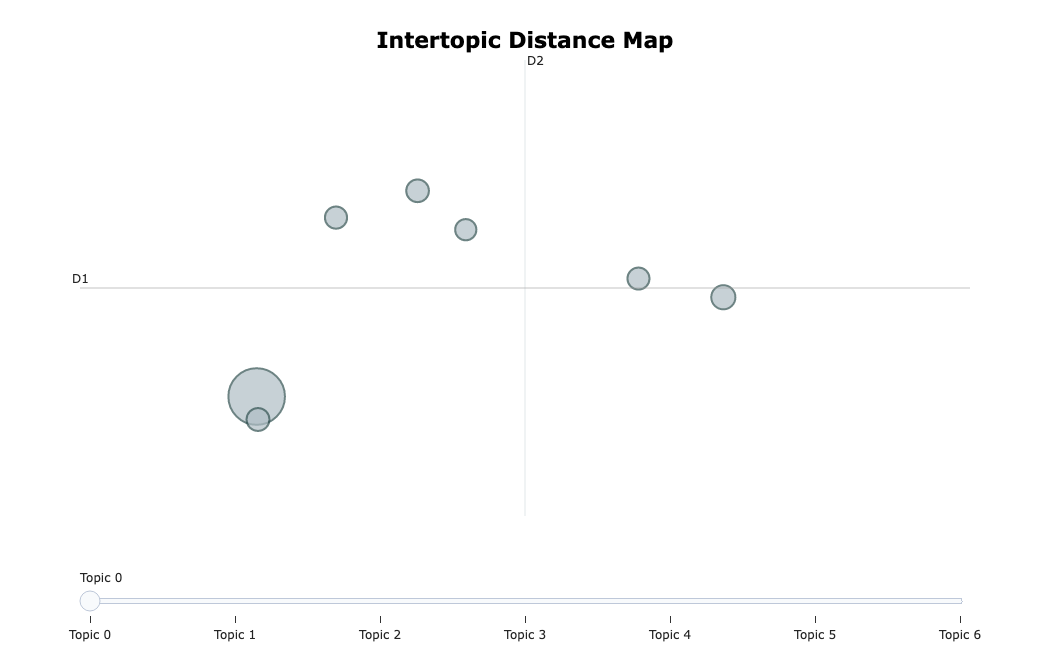

In [23]:
topic_model.visualize_topics()

Now let's look at the counts and names of the resulting topics.

In [24]:
topic_model.get_topic_info()

Topic  Count                                           Name
0     -1   7262                      -1_russia_russian_eu_nato
1      0   3642             0_ukraine_ukrainian_russian_russia
2      1    663                1_chemical_syria_syrian_helmets
3      2    598          2_crimea_referendum_annexation_russia
4      3    588           3_belarus_belarusian_protests_colour
5      4    561  4_coronavirus_biological_laboratories_covid19
6      5    554             5_navalny_poisoning_alexei_skripal
7      6    514            6_values_western_traditional_europe

We see  that stopwords are even more prominent than in the earlier run, so we remove them.

In [25]:
topic_model.update_topics(docs, vectorizer_model=vectorizer_model)
topic_info7 = topic_model.get_topic_info()
topic_info7

Topic  Count                                           Name
0     -1   7262                      -1_russia_russian_eu_nato
1      0   3642             0_ukraine_ukrainian_russian_russia
2      1    663                1_chemical_syria_syrian_helmets
3      2    598          2_crimea_referendum_annexation_russia
4      3    588           3_belarus_belarusian_protests_colour
5      4    561  4_coronavirus_biological_laboratories_covid19
6      5    554             5_navalny_poisoning_alexei_skripal
7      6    514            6_values_western_traditional_europe

We see that:

* The set of outliers, `Topic=-1`, now contains more than half the documents
* The names indicate an even larger focus on identities: "russian-russia", "ukraine-ukrainian", "eu-european", "belarus-belarusian", "soviet-ussr"

Let us look at more terms than the ones in the name and see how they relatively influence the identification of a topic.

## Term score decline

From the BERTopic documentation:
> Each topic is represented by a set of words. These words, however, do not all equally represent the topic. This visualization shows how many words are needed to represent a topic and at which point the beneficial effect of adding words starts to decline.

Topics have terms ranked by their c-TF-IDF scores. The term best identifying a topic has the highest ranking. If this score is relatively high, then the term is to a high degree an identifier for the topic. 

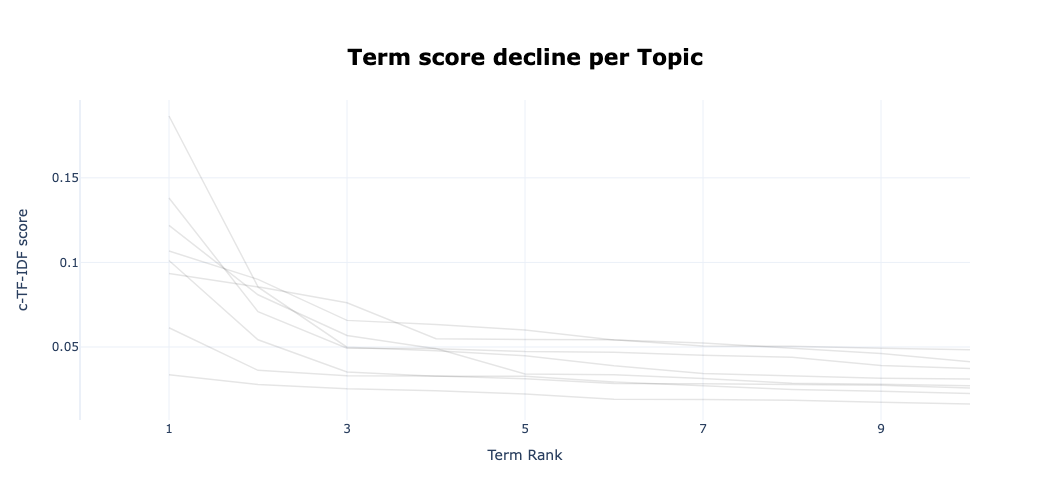

In [26]:
topic_model.visualize_term_rank()

We will now present an alternative view of this data, using the top lists of terms and their c-TF-IDF scores per topic. We will create two dataframes: the first with the terms, according to their ranking, the second with the c-TF-IDF scores for these terms.

In [27]:
def create_word_and_value_matrix(topic_model):
    d = {}
    d2 = {}
    topic_info = topic_model.get_topic_info()
    for i in range(-1, topic_info.shape[0]-1):
        d[f'{topic_model.topic_labels_[i]}'] = [x[0] for x in topic_model.get_topic(i)]
        d2[f'{topic_model.topic_labels_[i]}'] = [x[1] for x in topic_model.get_topic(i)]
    word_matrix = pd.DataFrame.from_dict(d).T
    value_matrix = pd.DataFrame.from_dict(d2).T
    return word_matrix, value_matrix
    
word_matrix, value_matrix = create_word_and_value_matrix(topic_model)
word_matrix

0           1  \
-1_russia_russian_eu_nato                           russia     russian   
0_ukraine_ukrainian_russian_russia                 ukraine   ukrainian   
1_chemical_syria_syrian_helmets                   chemical       syria   
2_crimea_referendum_annexation_russia               crimea  referendum   
3_belarus_belarusian_protests_colour               belarus  belarusian   
4_coronavirus_biological_laboratories_covid19  coronavirus  biological   
5_navalny_poisoning_alexei_skripal                 navalny   poisoning   
6_values_western_traditional_europe                 values     western   

                                                          2        3  \
-1_russia_russian_eu_nato                                eu     nato   
0_ukraine_ukrainian_russian_russia                  russian   russia   
1_chemical_syria_syrian_helmets                      syrian  helmets   
2_crimea_referendum_annexation_russia            annexation   russia   
3_belarus_belarusian_protests_colour               protests   colour   
4_coronavirus_biological_laboratories_covid19  laboratories  covid19   
5_navalny_poisoning_alexei_skripal                   alexei  skripal   
6_values_western_traditional_europe             traditional   europe   

                                                            4          5  \
-1_russia_russian_eu_nato                      disinformation     states   
0_ukraine_ukrainian_russian_russia                     donbas        war   
1_chemical_syria_syrian_helmets                         white     attack   
2_crimea_referendum_annexation_russia           international    illegal   
3_belarus_belarusian_protests_colour               revolution       west   
4_coronavirus_biological_laboratories_covid19           virus      china   
5_navalny_poisoning_alexei_skripal                   novichok    russian   
6_values_western_traditional_europe                    rights  societies   

                                                            6        7  \
-1_russia_russian_eu_nato                            european   poland   
0_ukraine_ukrainian_russian_russia             disinformation     2014   
1_chemical_syria_syrian_helmets                       attacks     opcw   
2_crimea_referendum_annexation_russia                 crimean     2014   
3_belarus_belarusian_protests_colour                   poland  western   
4_coronavirus_biological_laboratories_covid19          health    world   
5_navalny_poisoning_alexei_skripal                      agent   russia   
6_values_western_traditional_europe                      west   sexual   

                                                        8            9  
-1_russia_russian_eu_nato                      prokremlin    countries  
0_ukraine_ukrainian_russian_russia               military   prokremlin  
1_chemical_syria_syrian_helmets                     douma      weapons  
2_crimea_referendum_annexation_russia             ukraine    peninsula  
3_belarus_belarusian_protests_colour           opposition  revolutions  
4_coronavirus_biological_laboratories_covid19  conspiracy      viruses  
5_navalny_poisoning_alexei_skripal                  nerve     navalnys  
6_values_western_traditional_europe               liberal     children

In [28]:
value_matrix

0         1         2  \
-1_russia_russian_eu_nato                      0.033616  0.027760  0.025303   
0_ukraine_ukrainian_russian_russia             0.101102  0.054291  0.035232   
1_chemical_syria_syrian_helmets                0.106791  0.089992  0.065729   
2_crimea_referendum_annexation_russia          0.186559  0.085573  0.076188   
3_belarus_belarusian_protests_colour           0.138114  0.070862  0.049279   
4_coronavirus_biological_laboratories_covid19  0.093417  0.085458  0.049869   
5_navalny_poisoning_alexei_skripal             0.121880  0.080860  0.056850   
6_values_western_traditional_europe            0.061395  0.036207  0.032979   

                                                      3         4         5  \
-1_russia_russian_eu_nato                      0.024133  0.022276  0.019060   
0_ukraine_ukrainian_russian_russia             0.032742  0.032632  0.029340   
1_chemical_syria_syrian_helmets                0.063355  0.060021  0.054163   
2_crimea_referendum_annexation_russia          0.054898  0.054391  0.054336   
3_belarus_belarusian_protests_colour           0.049040  0.034063  0.033596   
4_coronavirus_biological_laboratories_covid19  0.047715  0.044781  0.038872   
5_navalny_poisoning_alexei_skripal             0.049010  0.047286  0.046913   
6_values_western_traditional_europe            0.032817  0.031235  0.028395   

                                                      6         7         8  \
-1_russia_russian_eu_nato                      0.018903  0.018464  0.017318   
0_ukraine_ukrainian_russian_russia             0.027042  0.024892  0.023788   
1_chemical_syria_syrian_helmets                0.052314  0.049206  0.046173   
2_crimea_referendum_annexation_russia          0.050530  0.050467  0.049272   
3_belarus_belarusian_protests_colour           0.031313  0.028578  0.028003   
4_coronavirus_biological_laboratories_covid19  0.034376  0.032724  0.031484   
5_navalny_poisoning_alexei_skripal             0.045090  0.043953  0.039104   
6_values_western_traditional_europe            0.028336  0.027639  0.027330   

                                                      9  
-1_russia_russian_eu_nato                      0.016293  
0_ukraine_ukrainian_russian_russia             0.022456  
1_chemical_syria_syrian_helmets                0.041219  
2_crimea_referendum_annexation_russia          0.048298  
3_belarus_belarusian_protests_colour           0.027019  
4_coronavirus_biological_laboratories_covid19  0.031122  
5_navalny_poisoning_alexei_skripal             0.037257  
6_values_western_traditional_europe            0.025720

To make sense of the numbers we will rescale them on a single scale between 0 and 1.

In [29]:
from sklearn.preprocessing import MinMaxScaler

def scale_value_matrix(value_matrix):
    scaler = MinMaxScaler()
    # We flatten the matrix to the equavalent of a single column, as the scaler works per column
    flat = value_matrix.to_numpy().reshape(-1,1) 
    # After scaling, we reshape the result into the previous matrix shape
    reshaped = scaler.fit_transform(flat).reshape(value_matrix.shape)
    df_scaled = pd.DataFrame(reshaped, index=value_matrix.index)
    return df_scaled

df_scaled = scale_value_matrix(value_matrix)
df_scaled

0         1         2  \
-1_russia_russian_eu_nato                      0.101740  0.067344  0.052914   
0_ukraine_ukrainian_russian_russia             0.498094  0.223167  0.111228   
1_chemical_syria_syrian_helmets                0.531506  0.432846  0.290341   
2_crimea_referendum_annexation_russia          1.000000  0.406888  0.351773   
3_belarus_belarusian_protests_colour           0.715474  0.320493  0.193727   
4_coronavirus_biological_laboratories_covid19  0.452959  0.406213  0.197196   
5_navalny_poisoning_alexei_skripal             0.620126  0.379213  0.238195   
6_values_western_traditional_europe            0.264891  0.116958  0.097997   

                                                      3         4         5  \
-1_russia_russian_eu_nato                      0.046042  0.035135  0.016249   
0_ukraine_ukrainian_russian_russia             0.096605  0.095959  0.076622   
1_chemical_syria_syrian_helmets                0.276401  0.256821  0.222416   
2_crimea_referendum_annexation_russia          0.226729  0.223755  0.223431   
3_belarus_belarusian_protests_colour           0.192325  0.104362  0.101624   
4_coronavirus_biological_laboratories_covid19  0.184543  0.167313  0.132605   
5_navalny_poisoning_alexei_skripal             0.192151  0.182025  0.179832   
6_values_western_traditional_europe            0.097043  0.087752  0.071075   

                                                      6         7         8  \
-1_russia_russian_eu_nato                      0.015326  0.012748  0.006020   
0_ukraine_ukrainian_russian_russia             0.063126  0.050499  0.044017   
1_chemical_syria_syrian_helmets                0.211554  0.193298  0.175487   
2_crimea_referendum_annexation_russia          0.201076  0.200707  0.193691   
3_belarus_belarusian_protests_colour           0.088212  0.072150  0.068770   
4_coronavirus_biological_laboratories_covid19  0.106202  0.096498  0.089215   
5_navalny_poisoning_alexei_skripal             0.169129  0.162448  0.133968   
6_values_western_traditional_europe            0.070727  0.066632  0.064817   

                                                      9  
-1_russia_russian_eu_nato                      0.000000  
0_ukraine_ukrainian_russian_russia             0.036195  
1_chemical_syria_syrian_helmets                0.146391  
2_crimea_referendum_annexation_russia          0.187967  
3_belarus_belarusian_protests_colour           0.062994  
4_coronavirus_biological_laboratories_covid19  0.087091  
5_navalny_poisoning_alexei_skripal             0.123124  
6_values_western_traditional_europe            0.055362

In [30]:
import re
from IPython.display import display, HTML

import matplotlib as mpl
import numpy as np

# From: https://stackoverflow.com/questions/25668828/how-to-create-colour-gradient-in-python
def colorFader(c1,c2,mix=0): 
    """fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)"""
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
        
    # Imprecision might lead to values < 0 and > 1 which are invalid for to_hex, so we clip them 
    return mpl.colors.to_hex(np.clip((1-mix)*c2 + mix*c1, 0, 1))

def colorize(val):
    c1 = 'red'      # highest value is red
    c2 = 'white'
    return colorFader(c1, c2, val)

In [31]:
def show_words(word_matrix, df_scaled, col_function=colorize):
    d_col = df_scaled.applymap(col_function).to_numpy()    
    styles = []
    for row in range(0, d_col.shape[0]):
        for col in range(0, d_col.shape[1]):
            c = d_col[row][col]
            styles.append({'selector': f'.row{row}.col{col}', 'props': [('background-color', c)]})

    # add style for the caption
    styles.append(dict(selector="caption", props=[("font-size", "150%"),('font-weight', 'bold')]))
    style = word_matrix.style.set_table_styles(styles)
    style.set_caption('Topic Term matrix')
    return style
    
show_words(word_matrix, df_scaled)

Now let's see what topics got attention over time.

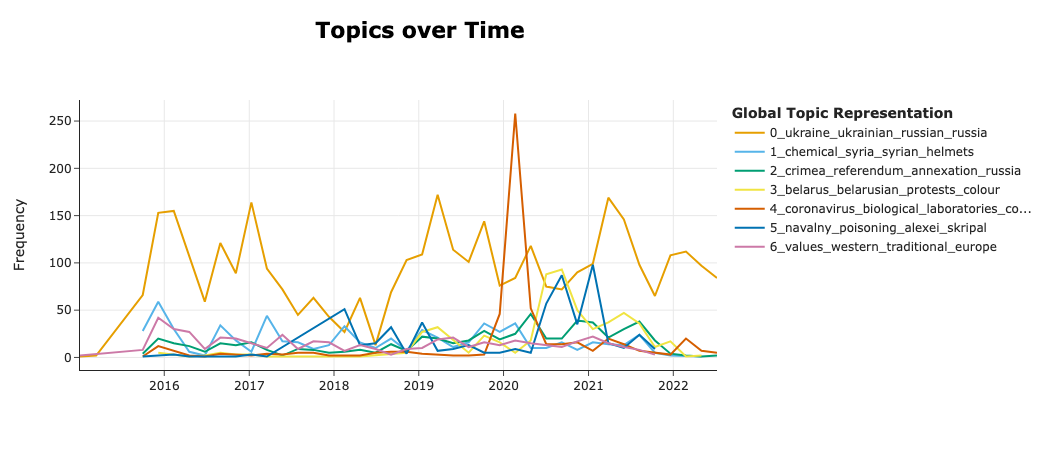

In [32]:
# BERTopic documentation advises no more than 20 bins, but I take 7 years * 6 two-month intervals = 42
# We set `global_tuning=False`, because we want the bins to be represented with words only from the time interval,
# not interpolated from the global set.
topics_over_time = topic_model.topics_over_time(
    docs, 
    disinfo['publication_date'].tolist(), 
    datetime_format="%Y-%m-%d %H:%M:%S", 
    nr_bins=42,
    global_tuning=False)
topic_model.visualize_topics_over_time(topics_over_time, width=1000)

We see a big peak in early 2020 for the topic with the most prominent term _coronavirus_. Otherwise, most topics have ups and downs in number of documents.

# Results and continuation






# Finer-grained topics

Earlier we minised the number of topics, based on a good number of them being found similar.

Let's now look at a larger set of topics and visualise their similarity using a dendrogram.

In [33]:
# Retrieve the original topic model we saved earlier
topic_model = BERTopic.load('disinfo_minsize100_clean.bertopic')

### Term-Score matrix

If we have only a division of our documents in clusters, our information would be like a list of indexes to documents where each index is paired with the id of one of the clusters.

What makes topic modelling go beyond basic clustering is that the process gives us for each cluster not only an id, but also a list of pairs of terms and scores. As we already saw, based on ranking of the scores, we can generate a name for the cluster consisting of the most relevant terms. See below how the terms in the name correspond to the highest ranking terms in this list for the topic.

In [34]:
topic_id = 7
t = topic_model.get_topic(topic_id)
one_topic = pd.DataFrame.from_dict({'Term': [x[0] for x in t], 'Score': [x[1] for x in t]})
print('Topic: ', topic_model.topic_labels_[topic_id])
one_topic

Topic:  7_coronavirus_virus_covid19_china


Term     Score
0  coronavirus  0.093940
1        virus  0.048167
2      covid19  0.047491
3        china  0.041193
4      chinese  0.032954
5     pandemic  0.031426
6      viruses  0.031299
7   biological  0.029914
8        world  0.027284
9   conspiracy  0.027176

In [35]:
word_matrix, value_matrix = create_word_and_value_matrix(topic_model)
df_scaled = scale_value_matrix(value_matrix)
show_words(word_matrix, df_scaled)

In [36]:
word_matrix, value_matrix = create_word_and_value_matrix(topic_model)
word_matrix

0                1  \
-1_russia_nato_disinformation_russian               russia             nato   
0_ukraine_ukrainian_donbas_war                     ukraine        ukrainian   
1_crimea_referendum_annexation_illegal              crimea       referendum   
2_belarus_belarusian_colour_protests               belarus       belarusian   
3_values_traditional_western_societies              values      traditional   
4_poland_pact_soviet_historical                     poland             pact   
5_nato_alliance_russia_exercises                      nato         alliance   
6_sanctions_russia_eu_russias                    sanctions           russia   
7_coronavirus_virus_covid19_china              coronavirus            virus   
8_syria_isis_daesh_terrorist                         syria             isis   
9_media_freedom_rt_estonia                           media          freedom   
10_mh17_jit_investigation_missile                     mh17              jit   
11_navalny_alexei_poisoning_navalnys               navalny           alexei   
12_eu_european_member_states                            eu         european   
13_chemical_helmets_white_syria                   chemical          helmets   
14_vaccine_sputnik_vaccines_ema                    vaccine          sputnik   
15_skripal_poisoning_nerve_salisbury               skripal        poisoning   
16_interference_election_2016_elections       interference         election   
17_poland_polish_lithuania_states                   poland           polish   
18_georgia_georgian_south_ossetia                  georgia         georgian   
19_biological_laboratories_lugar_weapons        biological     laboratories   
20_moldova_moldovan_sandu_maia                     moldova         moldovan   
21_italy_coronavirus_eu_response                     italy      coronavirus   
22_sea_waters_kerch_strait                             sea           waters   
23_election_trump_biden_fraud                     election            trump   
24_soros_george_foundation_society                   soros           george   
25_turkey_nagornokarabakh_azerbaijan_armenia        turkey  nagornokarabakh   
26_venezuela_venezuelan_bolivia_mexico           venezuela       venezuelan   

                                                           2           3  \
-1_russia_nato_disinformation_russian         disinformation     russian   
0_ukraine_ukrainian_donbas_war                        donbas         war   
1_crimea_referendum_annexation_illegal            annexation     illegal   
2_belarus_belarusian_colour_protests                  colour    protests   
3_values_traditional_western_societies               western   societies   
4_poland_pact_soviet_historical                       soviet  historical   
5_nato_alliance_russia_exercises                      russia   exercises   
6_sanctions_russia_eu_russias                             eu     russias   
7_coronavirus_virus_covid19_china                    covid19       china   
8_syria_isis_daesh_terrorist                           daesh   terrorist   
9_media_freedom_rt_estonia                                rt     estonia   
10_mh17_jit_investigation_missile              investigation     missile   
11_navalny_alexei_poisoning_navalnys               poisoning    navalnys   
12_eu_european_member_states                          member      states   
13_chemical_helmets_white_syria                        white       syria   
14_vaccine_sputnik_vaccines_ema                     vaccines         ema   
15_skripal_poisoning_nerve_salisbury                   nerve   salisbury   
16_interference_election_2016_elections                 2016   elections   
17_poland_polish_lithuania_states                  lithuania      states   
18_georgia_georgian_south_ossetia                      south     ossetia   
19_biological_laboratories_lugar_weapons               lugar     weapons   
20_moldova_moldovan_sandu_maia                         sandu        maia   
21_italy_coronavi

100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 300.28it/s]


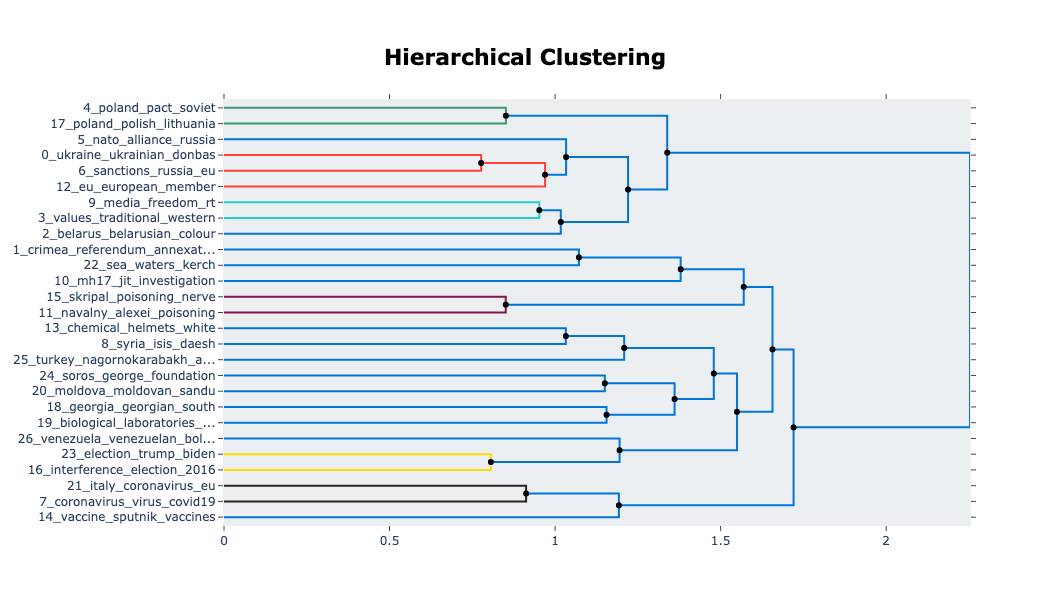

In [37]:
hierarchical_topics = topic_model.hierarchical_topics(docs)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [38]:
hierarchical_topics

Parent_ID                                        Parent_Name  \
25        52    ukraine_russia_russian_disinformation_ukrainian   
24        51   russian_crimea_russia_coronavirus_disinformation   
23        50                 crimea_russian_russia_navalny_mh17   
22        49                 crimea_mh17_navalny_russian_russia   
21        48           chemical_syria_georgia_evidence_election   
20        47          chemical_syria_georgia_biological_weapons   
19        46          crimea_mh17_referendum_russian_annexation   
18        45      georgia_biological_moldova_soros_laboratories   
17        44    ukraine_russia_ukrainian_russian_disinformation   
16        43                ukraine_russia_ukrainian_russian_eu   
15        42                chemical_syria_syrian_helmets_white   
14        41  election_elections_trump_interference_presiden...   
13        40       coronavirus_vaccine_sputnik_covid19_vaccines   
12        39     georgia_biological_laboratories_lugar_georgian   
11        38                soros_moldova_george_moldovan_sandu   
10        37  crimea_referendum_annexation_international_ill...   
9         36               ukraine_ukrainian_russia_nato_donbas   
8         35                chemical_syria_syrian_helmets_white   
7         34            belarus_belarusian_media_colour_western   
6         33                 ukraine_ukrainian_russia_donbas_eu   
5         32                    media_freedom_values_western_rt   
4         31           coronavirus_covid19_pandemic_virus_china   
3         30               poland_polish_pact_soviet_historical   
2         29          navalny_poisoning_alexei_skripal_novichok   
1         28         election_elections_trump_interference_2016   
0         27            ukraine_ukrainian_donbas_russia_russian   

                                               Topics Child_Left_ID  \
25  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...            44   
24  [1, 7, 8, 10, 11, 13, 14, 15, 16, 18, 19, 20, ...            50   
23  [1, 8, 10, 11, 13, 15, 16, 18, 19, 20, 22, 23,...            49   
22                                [1, 10, 11, 15, 22]            46   
21            [8, 13, 16, 18, 19, 20, 23, 24, 25, 26]            47   
20                        [8, 13, 18, 19, 20, 24, 25]            42   
19                                        [1, 10, 22]            37   
18                                   [18, 19, 20, 24]            38   
17                      [0, 2, 3, 4, 5, 6, 9, 12, 17]            30   
16                             [0, 2, 3, 5, 6, 9, 12]            36   
15                                        [8, 13, 25]            35   
14                                       [16, 23, 26]            26   
13                                        [7, 14, 21]            31   
12                                           [18, 19]            18   
11                                           [20, 24]            24   
10                                            [1, 22]             1   
9                                       [0, 5, 6, 12]             5   
8                                             [8, 13]            13   
7                                           [2, 3, 9]            32   
6                                          [0, 6, 12]            27   
5                                              [3, 9]             9   
4                                             [7, 21]            21   
3                                             [4, 17]             4   
2                                            [11, 15]            15   
1                                            [16, 23]            23   
0                                              [0, 6]             0   

                                      Child_Left_Name Child_Right_ID  \
25    ukraine_russia_ukrainian_russian_disinformation             51   
24                 crimea_russian_russia_navalny_mh17             40   
23                 crimea_mh17_navalny_russian_russia      

In [39]:
def make_tree(parent_id, tree_dict):
    tree = []
    if parent_id in tree_dict.keys():
        child_left_id, child_right_id, topics, distance = tree_dict[parent_id]
        tree = [parent_id, topics, distance, make_tree(child_left_id, tree_dict), make_tree(child_right_id, tree_dict)]
        return tree
    else:
        # this is a leaf
        return parent_id

In [40]:
#from copy import copy
def next_column(seed_column, tree_dict, tree):
    """Take a 'seed column' and convert all elements that are parents"""
    DEFAULT_DISTANCE = 0.5
    #print('seed column', seed_column, tree)
    # copy the seed column to a second column    
    if len(seed_column) == 1:
        #print('return seed column', seed_column)
        return seed_column
    
    next_column = seed_column.copy()
    
    i = 0
    while i < len(seed_column):
        elem = seed_column[i][0]
        elem_tree = find_tree(elem, tree)
        if elem_tree is None:
            # this is a leaf element, go to the next element
            i += 1
        else:
            left = elem_tree[3]
            right = elem_tree[4]
            distance = elem_tree[2]
            
            for child in elem_tree[3:5]:
                if type(child) is list:
                    child_elem = child[0]
                    child_topics = child[1]
                    for t in child_topics:
                        next_column[i] = (child_elem, t, distance)
                        i += 1
                else:
                    # the child is a leaf
                    next_column[i] = (child, child, DEFAULT_DISTANCE)
                    i += 1
    
    if not has_change_in_columns(seed_column, next_column):
        return None
    else:
        return next_column
    
    
def has_change_in_columns(c_in, c_out):
    """Compare the identifiers in two columns, these are the first elements of tuples"""
    for i in range(len(c_in)):
        if c_in[i][0] != c_out[i][0]:
            # element changed
            return True
    else:
        return False


def find_tree(elem, tree):
    """Find the subtree in `tree` where the given `elem` is a parent"""
    if type(tree) != list:
        return None
    
    if tree[0] == elem:
        return tree
    
    left = find_tree(elem, tree[3])
    if left:
        return left
    
    right = find_tree(elem, tree[4])
    if right:
        return right
    
    return None

def make_seed_column(tree):
    """Create a first column out of a tree"""
    outlist = []

    parent_id = tree[0]
    topics = tree[1]
    distance = tree[2]
    
    for child in tree[3:5]:
        if type(child) == list:
            child_topics = child[1]
            for t in child_topics:
                outlist.append((child[0], t, distance))

        else:
            # leaf
            outlist.append((child, child, 0.0))
            
    return outlist

In [41]:
def tree_to_matrix(tree, tree_dict):
    """Create a matrix from a tree"""
    seed_column = make_seed_column(tree)
    output = [seed_column]
    nc = next_column(seed_column, tree_dict, tree)
    while nc is not None:
        output.append(nc)
        nc = next_column(nc, tree_dict, tree)
                
    # Get leaf elements left by reversing the list
    output.reverse()
    
    # Sort all columns by the leaves
    new_output = [output[0]]
    sortlist = [x[1] for x in output[0]]
    for col in output[1:]:
        nc = []
        for e in sortlist:
            for parent, leaf, distance in col:
                if e == leaf:
                    nc.append((parent,leaf, distance))
        new_output.append(nc)
        
    return new_output

In [42]:
hierarchy = hierarchical_topics[['Parent_ID', 'Topics', 'Child_Left_ID', 'Child_Right_ID', 'Distance']].to_numpy()
tree_dict = {}
columns = []
root_id = None
for parent_id, topics, child_left_id, child_right_id, distance in hierarchy:
    if root_id is None:
        root_id = int(parent_id)
    tree_dict[int(parent_id)] = (int(child_left_id), int(child_right_id), topics, distance)

matrix = tree_to_matrix(make_tree(root_id, tree_dict), tree_dict)

In [43]:
# Element 2 (middle) is the same for all columns. Let's set it to an index_column
index_column = [y[1] for y in matrix[0]]
index_column

# Reduce the other columns
l = np.array(matrix)
s = l.shape
l = l.reshape(-1,3)
arr_ids = np.array([int(x[0]) for x in l]).reshape((s[0],s[1])).T

# We scale the distances
scaler = MinMaxScaler()
arr_distances = scaler.fit_transform([[x[2]] for x in l])
arr_distances = 1 - arr_distances
arr_distances = arr_distances.reshape((s[0],s[1])).T
hierarchy_ids_df = pd.DataFrame(arr_ids, index=index_column, dtype=object)
hierarchy_distances_df  = pd.DataFrame(arr_distances, index=index_column, dtype=object)


In [44]:
word_matrix2 = word_matrix.iloc[1:]
word_matrix2 = word_matrix2.reset_index()
word_matrix2.reindex_like(hierarchy_ids_df)

0                1              2           3             4  \
4         poland             pact         soviet  historical          ussr   
17        poland           polish      lithuania      states        policy   
5           nato         alliance         russia   exercises      military   
0        ukraine        ukrainian         donbas         war       russian   
6      sanctions           russia             eu     russias          west   
12            eu         european         member      states        europe   
9          media          freedom             rt     estonia       sputnik   
3         values      traditional        western   societies        rights   
2        belarus       belarusian         colour    protests    revolution   
1         crimea       referendum     annexation     illegal       crimean   
22           sea           waters          kerch      strait          azov   
10          mh17              jit  investigation     missile        flight   
15       skripal        poisoning          nerve   salisbury            uk   
11       navalny           alexei      poisoning    navalnys      novichok   
13      chemical          helmets          white       syria          opcw   
8          syria             isis          daesh   terrorist        syrian   
25        turkey  nagornokarabakh     azerbaijan     armenia         trend   
24         soros           george     foundation     society       armenia   
20       moldova         moldovan          sandu        maia  transnistria   
18       georgia         georgian          south     ossetia      abkhazia   
19    biological     laboratories          lugar     weapons    laboratory   
26     venezuela       venezuelan        bolivia      mexico        maduro   
23      election            trump          biden       fraud     elections   
16  interference         election           2016   elections       russian   
21         italy      coronavirus             eu    response      european   
7    coronavirus            virus        covid19       china       chinese   
14       vaccine          sputnik       vaccines         ema       covid19   

               5                  6  
4           wwii  molotovribbentrop  
17        baltic             united  
5          natos             threat  
0           2014             russia  
6        imposed          relations  
12     countries            germany  
9         speech           facebook  
3         europe             sexual  
2           west             poland  
1      peninsula      international  
22     ukrainian        territorial  
10           buk               shot  
15      skripals              agent  
11         agent           poisoned  
13         douma             attack  
8    afghanistan          terrorism  
25         weeks         escalation  
24          open        revolutions  
20      moldovas           republic  
18      georgias               2008  
19        health            georgia  
26         latin          president  
23  presidential               deep  
16        report           meddling  
21      pandemic         commission  
7       pandemic            viruses  
14       russian             trials

In [45]:
def make_word_matrix_with_hierarchy(word_matrix, value_matrix, hiearchy_ids_df, hierarchy_distances_df, max_terms=None):
    """Do everything:
    1. remove -1 cluster from word & value matrixes
    2. reset index of word and value matrixes, so it gets 0..n index corresponding to topic ids
    3. reset the column names of the two hierarchy matrixes to prevent duplicates
    4. sort index of word and scale matrixes according to index of label matrix
    5. merge word and hiearchy label matrixes, merge scale an distance matrixes
    6. Move first column back to index as we don't need a numerical index any more
    """
    # 1. Remove -1 topic row from dataframes
    # 2. and reset index so it will become 0..n
    word_matrix1 = word_matrix.iloc[1:].reset_index()
    value_matrix1 = value_matrix.iloc[1:].reset_index()
    
    if max_terms is not None and max_terms < len(word_matrix1.columns):
        # Note that the named index counts as a column, so we add 1
        word_matrix1 = word_matrix1[ word_matrix1.columns[:max_terms+1] ]
        value_matrix1 = value_matrix1[ value_matrix1.columns[:max_terms+1] ]
        
    # 3. Generate new column names for the hierarchy dataframe: convert 'n' to 'Ln'
    ids_df = hierarchy_ids_df.copy()
    distances_df = hierarchy_distances_df.copy()
    
    ids_df.columns = [f'L{x}' for x in ids_df.columns]
    distances_df.columns = ids_df.columns
    
    # 4. Sort word and value matrixes according to order of hierarchy matrix
    word_matrix1 = word_matrix1.reindex(hiearchy_ids_df.index)
    value_matrix1 = value_matrix1.reindex(hierarchy_ids_df.index)
    
    # 5. merge horizontally
    full_words = pd.concat([word_matrix1, ids_df], axis=1)
    full_values = pd.concat([value_matrix1, distances_df], axis=1)
    
    # 6. set index 
    full_words = full_words.set_index('index')
    full_values = full_values.set_index('index')
    
    return show_words(full_words, full_values)
    #return full_values


make_word_matrix_with_hierarchy(word_matrix, df_scaled, hierarchy_ids_df, hierarchy_distances_df, max_terms=5)

In the diagram we can look at the nodes connecting "smaller" topics into agglommerations. In the _plotly_ diagram we can point our mouse at such a node to see what its name would be, that is, what its most salient terms are.

As moving the mouse around is tiresome, we can alternatively present the tree in a text-based visualization. It requires a change of mind in reading:
* The tree now doesn't come together in the middle on the right, but at the top on the left.
* The "leaves" - original topics - are now not aligned to the edge on the left, but left-aligned to their place in the tree. Leaves are indicated by black dots.

In [46]:
tree = topic_model.get_topic_tree(hierarchical_topics)
display(HTML('<h2>Topic Hierarchy with Named Nodes</h2>'))
print(tree)

.
├─ukraine_russia_ukrainian_russian_disinformation
│    ├─poland_polish_pact_soviet_historical
│    │    ├─■──poland_pact_soviet_historical_ussr ── Topic: 4
│    │    └─■──poland_polish_lithuania_states_policy ── Topic: 17
│    └─ukraine_russia_ukrainian_russian_eu
│         ├─ukraine_ukrainian_russia_nato_donbas
│         │    ├─■──nato_alliance_russia_exercises_military ── Topic: 5
│         │    └─ukraine_ukrainian_russia_donbas_eu
│         │         ├─ukraine_ukrainian_donbas_russia_russian
│         │         │    ├─■──ukraine_ukrainian_donbas_war_russian ── Topic: 0
│         │         │    └─■──sanctions_russia_eu_russias_west ── Topic: 6
│         │         └─■──eu_european_member_states_europe ── Topic: 12
│         └─belarus_belarusian_media_colour_western
│              ├─media_freedom_values_western_rt
│              │    ├─■──media_freedom_rt_estonia_sputnik ── Topic: 9
│              │    └─■──values_traditional_western_societies_rights ── Topic: 3
│              └─■──b

In [47]:
hierarchical_topics.loc[ hierarchical_topics['Distance'] < 1.0]

Parent_ID                                 Parent_Name      Topics  \
6        33          ukraine_ukrainian_russia_donbas_eu  [0, 6, 12]   
5        32             media_freedom_values_western_rt      [3, 9]   
4        31    coronavirus_covid19_pandemic_virus_china     [7, 21]   
3        30        poland_polish_pact_soviet_historical     [4, 17]   
2        29   navalny_poisoning_alexei_skripal_novichok    [11, 15]   
1        28  election_elections_trump_interference_2016    [16, 23]   
0        27     ukraine_ukrainian_donbas_russia_russian      [0, 6]   

  Child_Left_ID                          Child_Left_Name Child_Right_ID  \
6            27  ukraine_ukrainian_donbas_russia_russian             12   
5             9         media_freedom_rt_estonia_sputnik              3   
4            21   italy_coronavirus_eu_response_european              7   
3             4       poland_pact_soviet_historical_ussr             17   
2            15     skripal_poisoning_nerve_salisbury_uk             11   
1            23     election_trump_biden_fraud_elections             16   
0             0     ukraine_ukrainian_donbas_war_russian              6   

                               Child_Right_Name  Distance  
6              eu_european_member_states_europe  0.969663  
5   values_traditional_western_societies_rights  0.952363  
4       coronavirus_virus_covid19_china_chinese  0.912465  
3         poland_polish_lithuania_states_policy  0.851499  
2    navalny_alexei_poisoning_navalnys_novichok  0.850950  
1  interference_election_2016_elections_russian  0.806015  
0              sanctions_russia_eu_russias_west  0.776629

In [48]:
def advice_on_merging(hierarchical_topics, threshold=1.0):
        res = hierarchical_topics.loc[ hierarchical_topics['Distance'] < 1.0].sort_values(by='Distance', ascending=True)
        for _, row in res.iterrows():
            parent_id = row['Parent_ID']
            parent_name = row['Parent_Name']
            topics = row['Topics']
            distance = row['Distance']
            
            print(f'{parent_id}. {parent_name} (distance={distance})')
            for t in topics:
                print(' - ', topic_model.topic_labels_[t])
            
advice_on_merging(hierarchical_topics)

27. ukraine_ukrainian_donbas_russia_russian (distance=0.7766294707911453)
 -  0_ukraine_ukrainian_donbas_war
 -  6_sanctions_russia_eu_russias
28. election_elections_trump_interference_2016 (distance=0.8060145998029818)
 -  16_interference_election_2016_elections
 -  23_election_trump_biden_fraud
29. navalny_poisoning_alexei_skripal_novichok (distance=0.8509501558826625)
 -  11_navalny_alexei_poisoning_navalnys
 -  15_skripal_poisoning_nerve_salisbury
30. poland_polish_pact_soviet_historical (distance=0.8514993891287376)
 -  4_poland_pact_soviet_historical
 -  17_poland_polish_lithuania_states
31. coronavirus_covid19_pandemic_virus_china (distance=0.9124651916531932)
 -  7_coronavirus_virus_covid19_china
 -  21_italy_coronavirus_eu_response
32. media_freedom_values_western_rt (distance=0.952362624057608)
 -  3_values_traditional_western_societies
 -  9_media_freedom_rt_estonia
33. ukraine_ukrainian_russia_donbas_eu (distance=0.969663321648743)
 -  0_ukraine_ukrainian_donbas_war
 -  6_s

In [49]:
def find_topics_for_name(node_name, hierarchical_topics):
    """Get topic ids for all topics in a tree under the node with name `node_name`. If node_name has a duplicate,
    choose the one with the largest number of topics under it"""
    node = hierarchical_topics.loc[ hierarchical_topics['Parent_Name'] == node_name]
    if len(node) > 0:
        node['topic_len'] = node['Topics'].apply(len)
        node = node.sort_values(by='topic_len', ascending=False)
        topics = node.iloc[0]['Topics']
        return topics
    else:
        raise ValueError(f"Failed to find node for '{node_name}'")

In [50]:
topics = find_topics_for_name('navalny_poisoning_alexei_skripal_novichok', hierarchical_topics)
topics
#coronavirus_vaccine_sputnik_covid19_vaccines

[11, 15]

Now, let's look at one connection in the diagram. The tooltip gives it the name _"coronavirus_covid19_vaccine_biological_soros"_. We can look up the identifiers of the different topics underneath by following the lines in the diagram, but, well, that's not the kind of thing one does, so instead we get the topic identifiers from the `hierarchical_topics` dataframe.

In [51]:
# BERTopic documentation advises no more than 20 bins, but I take 7 years * 6 two-month intervals = 42
topics_over_time = topic_model.topics_over_time(docs, disinfo['publication_date'].tolist(), datetime_format="%Y-%m-%d %H:%M:%S", nr_bins=42)

In [52]:
topics_over_time

Topic                                              Words  Frequency  \
0       -1       bratislava, exams, students, networks, rally          2   
1        0  organized, americans, revolution, repeating, d...          1   
2        3    statesupported, tradition, abuse, usled, sexual          2   
3        0  solely, daesh, training, directed, russiandescent          2   
4       -1      kamsholmen, locals, island, exercise, mistook          1   
..     ...                                                ...        ...   
832      9        propaganda, bloomberg, france, wedge, drive          1   
833     12                eu, european, states, europe, union          4   
834     19  biological, laboratories, weapons, ukraine, lugar          5   
835     20  moldova, transnistria, transnistrian, republic...          1   
836     21           energy, european, crisis, eu, solidarity          2   

                  Timestamp  
0   2015-01-03 04:37:55.200  
1   2015-01-03 04:37:55.200  
2   2015-01-03 04:37:55.200  
3   2015-03-13 20:00:00.000  
4   2015-05-19 16:00:00.000  
..                      ...  
832 2022-07-08 04:00:00.000  
833 2022-07-08 04:00:00.000  
834 2022-07-08 04:00:00.000  
835 2022-07-08 04:00:00.000  
836 2022-07-08 04:00:00.000  

[837 rows x 4 columns]

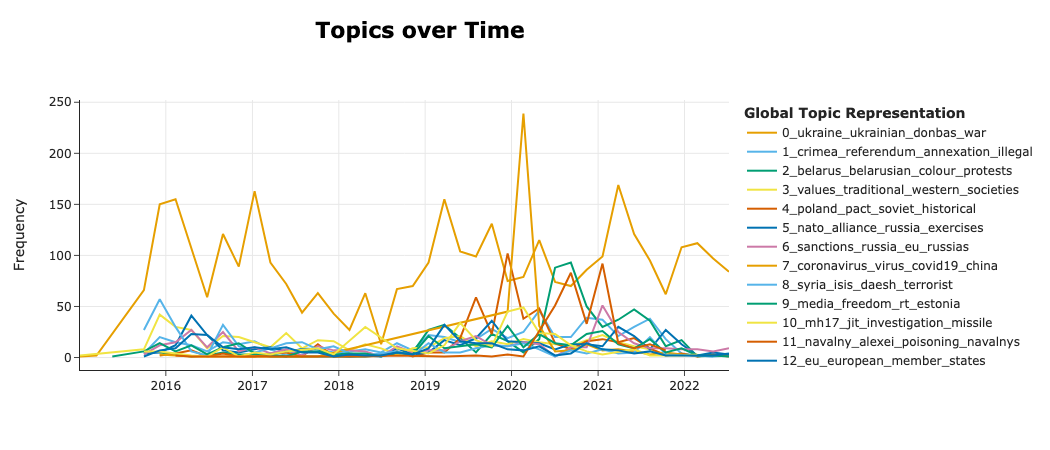

In [53]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=13, width=1000)

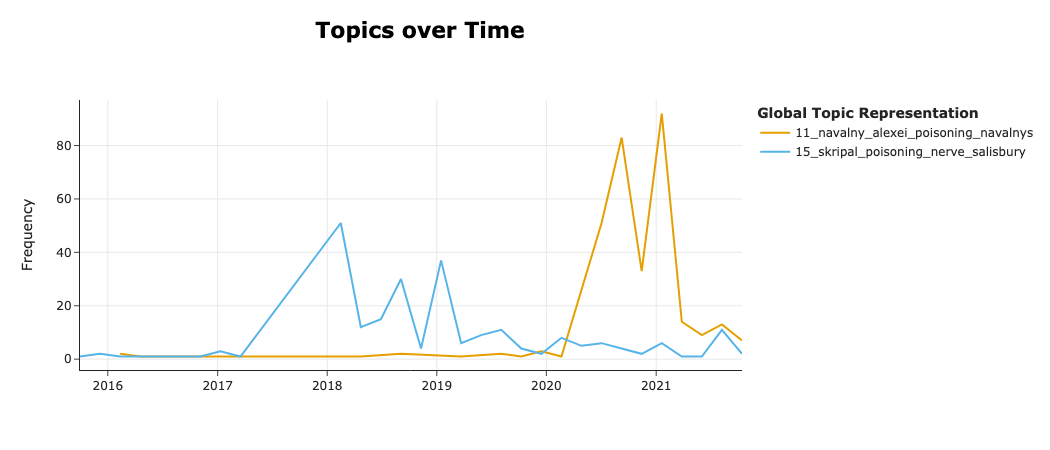

In [54]:
topic_model.visualize_topics_over_time(topics_over_time, width=1000, topics=topics)

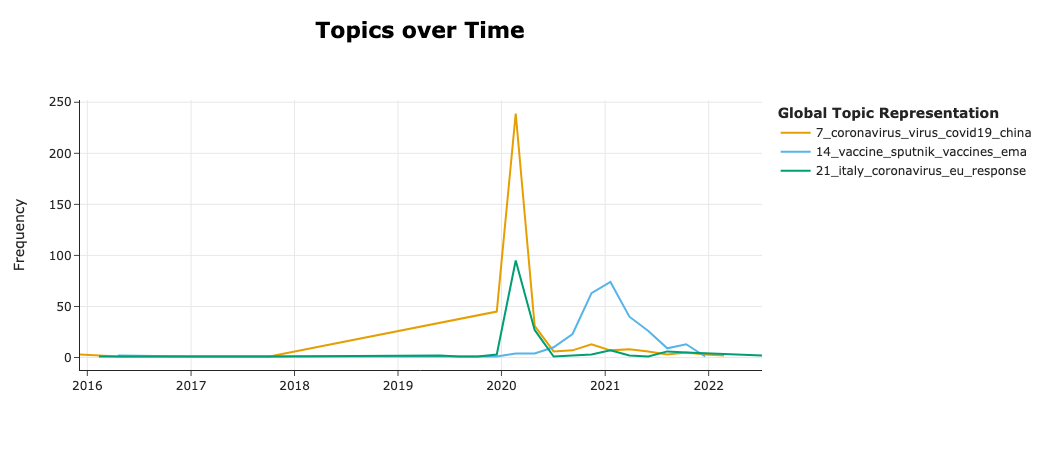

In [55]:
topics = find_topics_for_name('coronavirus_vaccine_sputnik_covid19_vaccines', hierarchical_topics)
topic_model.visualize_topics_over_time(topics_over_time, width=1000, topics=topics)

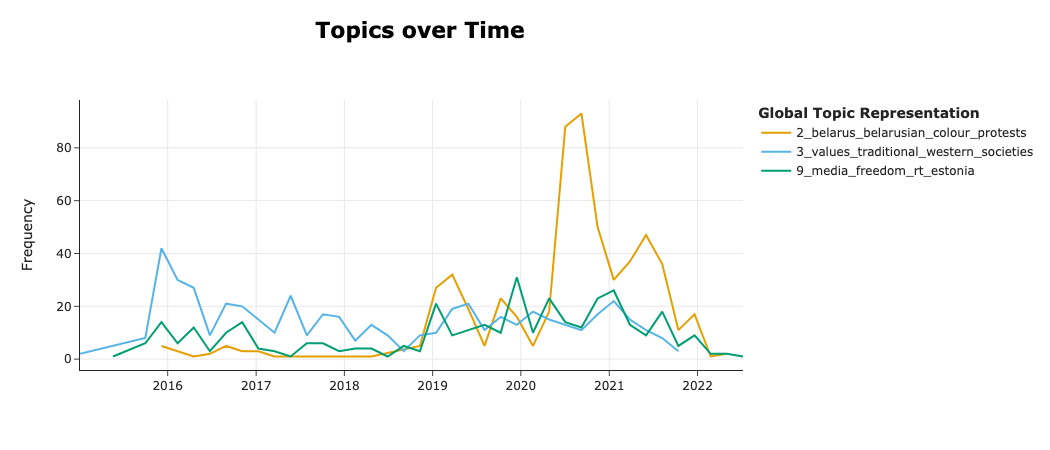

In [56]:
topics = find_topics_for_name('belarus_belarusian_media_colour_western', hierarchical_topics)
topic_model.visualize_topics_over_time(topics_over_time, width=1000, topics=topics)

In [57]:
def find_topics_by_search(search, topic_model, threshold=0.3):
    """Verbose wrapper around BERTopic's find_topics which filters out outliers and similarities lower than threshold"""
    similar_topics, similarity = topic_model.find_topics(search)
    labels = topic_model.generate_topic_labels()
    print(f"Similar topics for the word '{search}' (similarity threshold={threshold:.2f}):")
    res = []
    for t, s in zip(similar_topics, similarity):
        if t != -1 and s >= threshold:
            print(f'- {labels[t+1]} ({s:.3f})')   
            res.append(t)
    return res

Similar topics for the word 'european union and sanctions' (similarity threshold=0.40):
- 6_sanctions_russia_eu (0.609)
- 12_eu_european_member (0.489)
- 5_nato_alliance_russia (0.438)


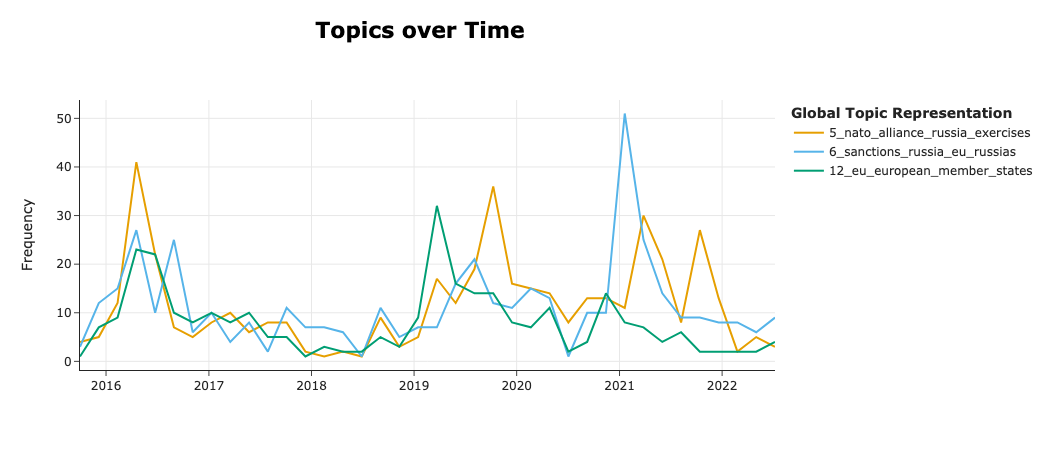

In [58]:
search = 'european union and sanctions'
topics = find_topics_by_search(search, topic_model, threshold=0.4)
topic_model.visualize_topics_over_time(topics_over_time, width=1000, topics=topics)

In [59]:
topics_over_time.head(20)

Topic                                              Words  Frequency  \
0      -1       bratislava, exams, students, networks, rally          2   
1       0  organized, americans, revolution, repeating, d...          1   
2       3    statesupported, tradition, abuse, usled, sexual          2   
3       0  solely, daesh, training, directed, russiandescent          2   
4      -1      kamsholmen, locals, island, exercise, mistook          1   
5       9        online, speech, hate, negatively, companies          1   
6      -1                 paris, trend, weeks, serbia, media         26   
7       0             trend, ukraine, weeks, ukrainian, isis         66   
8       1  crimea, electricity, khudilaynen, cutoff, bloc...          4   
9       3         norway, refugees, finland, underaged, flow          8   
10      5         nato, diverts, outposts, scaring, uniforms          4   
11      6            encounter, dust, russia, ignores, panic          3   
12      8                      isis, syria, daesh, usa, isil         27   
13      9               media, estonia, rt, freedom, biasing          6   
14     10    mh17, dutch, investigation, inaccurate, servies          6   
15     12              britons, indicates, survey, poll, orb          1   
16     13           foto, bitly1mrhha4, tragedy, fake, using          1   
17     15  22minutevideo, case, inconsistencies, devoted, uk          1   
18     18  georgia, protected, wwweconomistcomnode1192099...          1   
19     19  meningitis, stanytsya, separatist, mass, outbreak          1   

                 Timestamp                                      Name  
0  2015-01-03 04:37:55.200     -1_russia_nato_disinformation_russian  
1  2015-01-03 04:37:55.200            0_ukraine_ukrainian_donbas_war  
2  2015-01-03 04:37:55.200    3_values_traditional_western_societies  
3  2015-03-13 20:00:00.000            0_ukraine_ukrainian_donbas_war  
4  2015-05-19 16:00:00.000     -1_russia_nato_disinformation_russian  
5  2015-05-19 16:00:00.000                9_media_freedom_rt_estonia  
6  2015-09-30 08:00:00.000     -1_russia_nato_disinformation_russian  
7  2015-09-30 08:00:00.000            0_ukraine_ukrainian_donbas_war  
8  2015-09-30 08:00:00.000    1_crimea_referendum_annexation_illegal  
9  2015-09-30 08:00:00.000    3_values_traditional_western_societies  
10 2015-09-30 08:00:00.000          5_nato_alliance_russia_exercises  
11 2015-09-30 08:00:00.000             6_sanctions_russia_eu_russias  
12 2015-09-30 08:00:00.000              8_syria_isis_daesh_terrorist  
13 2015-09-30 08:00:00.000                9_media_freedom_rt_estonia  
14 2015-09-30 08:00:00.000         10_mh17_jit_investigation_missile  
15 2015-09-30 08:00:00.000              12_eu_european_member_states  
16 2015-09-30 08:00:00.000           13_chemical_helmets_white_syria  
17 2015-09-30 08:00:00.000      15_skripal_poisoning_nerve_salisbury  
18 2015-09-30 08:00:00.000         18_georgia_georgian_south_ossetia  
19 2015-09-30 08:00:00.000  19_biological_laboratories_lugar_weapons

In [60]:
topic_id = 7
topic_name = topic_model.topic_labels_[topic_id]
topic_words = topics_over_time[ topics_over_time['Name'] == topic_name]['Words'].tolist()

In [61]:
topic_model.topic_labels_

{-1: '-1_russia_nato_disinformation_russian',
 0: '0_ukraine_ukrainian_donbas_war',
 1: '1_crimea_referendum_annexation_illegal',
 2: '2_belarus_belarusian_colour_protests',
 3: '3_values_traditional_western_societies',
 4: '4_poland_pact_soviet_historical',
 5: '5_nato_alliance_russia_exercises',
 6: '6_sanctions_russia_eu_russias',
 7: '7_coronavirus_virus_covid19_china',
 8: '8_syria_isis_daesh_terrorist',
 9: '9_media_freedom_rt_estonia',
 10: '10_mh17_jit_investigation_missile',
 11: '11_navalny_alexei_poisoning_navalnys',
 12: '12_eu_european_member_states',
 13: '13_chemical_helmets_white_syria',
 14: '14_vaccine_sputnik_vaccines_ema',
 15: '15_skripal_poisoning_nerve_salisbury',
 16: '16_interference_election_2016_elections',
 17: '17_poland_polish_lithuania_states',
 18: '18_georgia_georgian_south_ossetia',
 19: '19_biological_laboratories_lugar_weapons',
 20: '20_moldova_moldovan_sandu_maia',
 21: '21_italy_coronavirus_eu_response',
 22: '22_sea_waters_kerch_strait',
 23: '23

In [62]:
l = []
remove_top_words = 5
primary_topic_words = [x[0] for x in topic_model.get_topic(topic_id)[:remove_top_words]]
for words in topic_words:
    word_list = [x.strip() for x in words.split(',')]
    w = [y for y in word_list if y not in primary_topic_words]
    l.append(w)
print(f'The primary {remove_top_words} terms for "{topic_model.topic_labels_[topic_id]}" are:\n{primary_topic_words}\n')
print("The remaining words per interval are:")
l

The primary 5 terms for "7_coronavirus_virus_covid19_china" are:
['coronavirus', 'virus', 'covid19', 'china', 'chinese']

The remaining words per interval are:


[['zika', 'companies', 'owned', 'available'],
 ['nwo', 'reduce', 'worlds', 'entertaining', 'planning'],
 ['zika', 'patent', 'owns', 'rockefeller'],
 ['100', 'million', 'communism', 'regimes', 'hat'],
 ['viruses'],
 [],
 ['pandemic'],
 ['pandemic'],
 ['pandemic'],
 ['pandemic', 'world', 'global'],
 ['pandemic', 'reset'],
 ['biological', 'laboratories'],
 ['pandemic', 'biological'],
 ['pandemic', 'pharma', 'big'],
 ['biological', 'pandemic'],
 ['reset', 'great', 'pandemic'],
 ['biological', 'laboratories']]

Here we see a relatively stable set of words over time, although it is remarkable that _sanctions_ and _russia_ don't appear in the global list of primary words for the topic.

In [63]:
topic_model.get_topic(7)

[('coronavirus', 0.09394017253159752),
 ('virus', 0.04816740779837609),
 ('covid19', 0.04749131169634931),
 ('china', 0.041192623790224286),
 ('chinese', 0.03295415174019802),
 ('pandemic', 0.03142563259563861),
 ('viruses', 0.0312986630602647),
 ('biological', 0.02991423907514245),
 ('world', 0.02728402383917956),
 ('conspiracy', 0.027176172384370215)]

# Merging topics

Besides running an algorithm to reduce the number of topics, BERTopic allows to merge a number of topics. One reason for doing this can be that a number of topics are related - e.g. as seen in the topic hierarchy - and we are not very interested in distinguishing between them.

In [64]:
# We create a new topic_model based on the existing model by loading it from a file
# Reason: We will now perform merges and that will change the topic_model, this means that if
# after merging we go up to a higher cell in the notebook, the topic_model will have been modified
tm2 = BERTopic.load('disinfo_minsize100_clean.bertopic')

In [65]:
print("Merging:")
for t in topics:
    print(f'- {tm2.topic_labels_[t]}')

Merging:
- 6_sanctions_russia_eu_russias
- 12_eu_european_member_states
- 5_nato_alliance_russia_exercises


In [66]:
tm2.merge_topics(docs, topics)
tm2.get_topic_info()

Topic  Count                                          Name
0      -1   3175         -1_russia_nato_disinformation_russian
1       0   3496                0_ukraine_ukrainian_donbas_war
2       1   1174                    1_nato_russia_eu_sanctions
3       2    598        2_crimea_referendum_annexation_illegal
4       3    588          3_belarus_belarusian_colour_protests
5       4    514        4_values_traditional_western_societies
6       5    464               5_poland_pact_soviet_historical
7       6    381             6_coronavirus_virus_covid19_china
8       7    372                  7_syria_isis_daesh_terrorist
9       8    368                    8_media_freedom_rt_estonia
10      9    352              9_mh17_jit_investigation_missile
11     10    317          10_navalny_alexei_poisoning_navalnys
12     11    291               11_chemical_helmets_white_syria
13     12    276               12_vaccine_sputnik_vaccines_ema
14     13    237          13_skripal_poisoning_nerve_salisbury
15     14    230       14_interference_election_2016_elections
16     15    203             15_poland_polish_lithuania_states
17     16    189             16_georgia_georgian_south_ossetia
18     17    180      17_biological_laboratories_lugar_weapons
19     18    166                18_moldova_moldovan_sandu_maia
20     19    162              19_italy_coronavirus_eu_response
21     20    146                    20_sea_waters_kerch_strait
22     21    137                 21_election_trump_biden_fraud
23     22    137            22_soros_george_foundation_society
24     23    127  23_turkey_nagornokarabakh_azerbaijan_armenia
25     24    102        24_venezuela_venezuelan_bolivia_mexico

In [67]:
search = 'coronavirus in italy'
similar_topics = find_topics_by_search(search, topic_model)


Similar topics for the word 'coronavirus in italy' (similarity threshold=0.30):
- 7_coronavirus_virus_covid19 (0.582)
- 21_italy_coronavirus_eu (0.485)
- 14_vaccine_sputnik_vaccines (0.380)


> <font color='red'>Note that the outliers are included in the possible result of `find_topics`!</font>

In [68]:
# Set custom labels for readability
topic_labels = topic_model.generate_topic_labels(nr_words=3,
                                            topic_prefix=True,
                                            separator="_")
topic_model.set_topic_labels(topic_labels)
topic_model.set_topic_labels({22: "22_Kerch Strait", 1: "1_Crimea", 8: "8_Sanctions", 0:  "0_Ukraine/Donbas", -1: "-1_Disinformation"})
topic_model.custom_labels_

['-1_Disinformation',
 '0_Ukraine/Donbas',
 '1_Crimea',
 '2_belarus_belarusian_colour',
 '3_values_traditional_western',
 '4_poland_pact_soviet',
 '5_nato_alliance_russia',
 '6_sanctions_russia_eu',
 '7_coronavirus_virus_covid19',
 '8_Sanctions',
 '9_media_freedom_rt',
 '10_mh17_jit_investigation',
 '11_navalny_alexei_poisoning',
 '12_eu_european_member',
 '13_chemical_helmets_white',
 '14_vaccine_sputnik_vaccines',
 '15_skripal_poisoning_nerve',
 '16_interference_election_2016',
 '17_poland_polish_lithuania',
 '18_georgia_georgian_south',
 '19_biological_laboratories_lugar',
 '20_moldova_moldovan_sandu',
 '21_italy_coronavirus_eu',
 '22_Kerch Strait',
 '23_election_trump_biden',
 '24_soros_george_foundation',
 '25_turkey_nagornokarabakh_azerbaijan',
 '26_venezuela_venezuelan_bolivia']